In [1]:
import pandas as pd
from IPython.display import display
# Ensure other common libraries like numpy, matplotlib, seaborn are imported
# in a common cell at the beginning of the notebook, as per previous discussions.
# For NetworkX, it will be imported when first used.

# Define the path to our custom transaction dataset
TRANSACTION_DATA_PATH = "fraud_transactions.csv" 

try:
    transactions_df = pd.read_csv(TRANSACTION_DATA_PATH)
    print(f"'{TRANSACTION_DATA_PATH}' loaded successfully.")
    print("--------------------------------------------------")
    print("First few rows of the transaction dataset:")
    display(transactions_df.head()) # Display more rows if needed, e.g., head(10)
    print("\n--------------------------------------------------")
    print(f"Dataset Shape: {transactions_df.shape}")
    print("--------------------------------------------------")
    # Basic info about data types and missing values
    print("Dataset Info:")
    transactions_df.info()
    print("--------------------------------------------------")
    if 'is_fraud' in transactions_df.columns:
        print("Distribution of 'is_fraud' label:")
        display(transactions_df['is_fraud'].value_counts(normalize=True).reset_index().rename(
            columns={'index': 'Is_Fraud', 'is_fraud': 'Proportion'}
        ))
    else:
        print("Note: 'is_fraud' column not found. Analysis will proceed without it for now.")
    print("--------------------------------------------------")
    
except FileNotFoundError:
    print(f"Error: '{TRANSACTION_DATA_PATH}' was not found.")
    print("Please ensure you have this file from the book's GitHub repository (chapter09/data folder)")
    print("and that it is in the correct path relative to your Jupyter Notebook.")
    transactions_df = None # Set to None if loading fails

'fraud_transactions.csv' loaded successfully.
--------------------------------------------------
First few rows of the transaction dataset:


,transaction_id,user_id,transaction_time,ip,device_id,phone_number,credit_card_number,order_item,amount,is_fraud
0,05987d33-9bcd-4455-9d7c-2f043b007b10,0,2024-05-07,219.20.206.172,8efe3214-ea7f-47ef-bb30-716e28f02600,(527)638-2221x33874,4908554227138584,Accessories,201631,False
1,013414be-3e37-48fb-aab2-5f42a4933db8,0,2024-05-09,219.20.206.172,8efe3214-ea7f-47ef-bb30-716e28f02600,(527)638-2221x33874,4908554227138584,Kids Products,281063,False
2,c6d1eed6-2c40-44f0-8a6f-fec0f8f7a83b,0,2024-05-12,219.20.206.172,8efe3214-ea7f-47ef-bb30-716e28f02600,(527)638-2221x33874,4908554227138584,Cosmetics,279119,False
3,90321501-3b4f-4cd3-92e9-ae1531b6b705,0,2024-05-01,219.20.206.172,8efe3214-ea7f-47ef-bb30-716e28f02600,(527)638-2221x33874,4908554227138584,Accessories,253019,False
4,2169fe4b-772a-45ef-9478-dbc48ee0e331,0,2024-05-09,219.20.206.172,8efe3214-ea7f-47ef-bb30-716e28f02600,(527)638-2221x33874,4908554227138584,Food,170733,False



--------------------------------------------------
Dataset Shape: (14813, 10)
--------------------------------------------------
Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14813 entries, 0 to 14812
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   transaction_id      14813 non-null  object
 1   user_id             14813 non-null  int64 
 2   transaction_time    14813 non-null  object
 3   ip                  14813 non-null  object
 4   device_id           14813 non-null  object
 5   phone_number        14813 non-null  object
 6   credit_card_number  14813 non-null  int64 
 7   order_item          14813 non-null  object
 8   amount              14813 non-null  int64 
 9   is_fraud            14813 non-null  bool  
dtypes: bool(1), int64(3), object(6)
memory usage: 1.0+ MB
--------------------------------------------------
Distribution of 'is_fraud' label:


,Proportion,proportion
0,False,0.982245
1,True,0.017755


--------------------------------------------------


In [15]:
import networkx as nx
import pandas as pd
from community import community_louvain
import matplotlib.pyplot as plt
from itertools import combinations
from collections import defaultdict
from concurrent.futures import ThreadPoolExecutor, as_completed

In [11]:
DATA_PATH_CH9 = "fraud_transactions.csv" # Path to the transaction data

try:
    transactions_df = pd.read_csv(DATA_PATH_CH9)
    print(f"'{DATA_PATH_CH9}' loaded successfully.")
    print("--------------------------------------------------")
    print("First 5 rows of the transaction dataset:")
    display(transactions_df.head())
    print("\n--------------------------------------------------")
    print(f"Dataset Shape: {transactions_df.shape}")
    print("--------------------------------------------------")
    print("Dataset Info:")
    transactions_df.info()
    print("\n--------------------------------------------------")
    if 'is_fraud' in transactions_df.columns:
        print("Distribution of 'is_fraud' label:")
        display(transactions_df['is_fraud'].value_counts(normalize=True).reset_index().rename(
            columns={'index': 'Is_Fraud', 'is_fraud': 'Proportion'}
        ))
    else:
        print("Note: 'is_fraud' column not found.")
    print("--------------------------------------------------")
except FileNotFoundError:
    print(f"Error: '{DATA_PATH_CH9}' not found. Please ensure the file is available.")
    transactions_df = None

'fraud_transactions.csv' loaded successfully.
--------------------------------------------------
First 5 rows of the transaction dataset:


,transaction_id,user_id,transaction_time,ip,device_id,phone_number,credit_card_number,order_item,amount,is_fraud
0,05987d33-9bcd-4455-9d7c-2f043b007b10,0,2024-05-07,219.20.206.172,8efe3214-ea7f-47ef-bb30-716e28f02600,(527)638-2221x33874,4908554227138584,Accessories,201631,False
1,013414be-3e37-48fb-aab2-5f42a4933db8,0,2024-05-09,219.20.206.172,8efe3214-ea7f-47ef-bb30-716e28f02600,(527)638-2221x33874,4908554227138584,Kids Products,281063,False
2,c6d1eed6-2c40-44f0-8a6f-fec0f8f7a83b,0,2024-05-12,219.20.206.172,8efe3214-ea7f-47ef-bb30-716e28f02600,(527)638-2221x33874,4908554227138584,Cosmetics,279119,False
3,90321501-3b4f-4cd3-92e9-ae1531b6b705,0,2024-05-01,219.20.206.172,8efe3214-ea7f-47ef-bb30-716e28f02600,(527)638-2221x33874,4908554227138584,Accessories,253019,False
4,2169fe4b-772a-45ef-9478-dbc48ee0e331,0,2024-05-09,219.20.206.172,8efe3214-ea7f-47ef-bb30-716e28f02600,(527)638-2221x33874,4908554227138584,Food,170733,False



--------------------------------------------------
Dataset Shape: (14813, 10)
--------------------------------------------------
Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14813 entries, 0 to 14812
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   transaction_id      14813 non-null  object
 1   user_id             14813 non-null  int64 
 2   transaction_time    14813 non-null  object
 3   ip                  14813 non-null  object
 4   device_id           14813 non-null  object
 5   phone_number        14813 non-null  object
 6   credit_card_number  14813 non-null  int64 
 7   order_item          14813 non-null  object
 8   amount              14813 non-null  int64 
 9   is_fraud            14813 non-null  bool  
dtypes: bool(1), int64(3), object(6)
memory usage: 1.0+ MB

--------------------------------------------------
Distribution of 'is_fraud' label:


,Proportion,proportion
0,False,0.982245
1,True,0.017755


--------------------------------------------------


In [21]:

if transactions_df is not None:
    G = nx.Graph() 

    node_types_and_columns = {
        'user': 'user_id', 'ip': 'ip', 'device': 'device_id',
        'phone': 'phone_number', 'card': 'credit_card_number'
    }

    print("Preparing nodes for the graph...")
    for node_type, col_name in node_types_and_columns.items():
        for entity_id in transactions_df[col_name].unique():
            G.add_node(f"{node_type}_{entity_id}", type=node_type) 
    print(f"Initial nodes added. Total nodes: {G.number_of_nodes()}")

    edges_to_add_with_attributes = defaultdict(lambda: {'weight': 0, 'transactions': []})

    def process_transaction_row(index_row_tuple):
        # (process_transaction_row function definition from previous answer)
        index, row = index_row_tuple
        transaction_entities_in_row = []
        for node_type_key, col_name_val in node_types_and_columns.items():
            transaction_entities_in_row.append(f"{node_type_key}_{row[col_name_val]}")
        row_edges = []
        for node1, node2 in combinations(sorted(transaction_entities_in_row), 2):
            row_edges.append(((node1, node2), row['transaction_id']))
        return row_edges

    print("\nProcessing transactions in parallel to prepare edge data...")
    prepared_edges_nested_list = []
    with ThreadPoolExecutor(max_workers=8) as executor: # Using 8 worker threads
        futures = [executor.submit(process_transaction_row, item) for item in transactions_df.iterrows()]
        count = 0
        for future in as_completed(futures):
            prepared_edges_nested_list.extend(future.result())
            count += 1
            if count % 1000 == 0 and count > 0: # Print progress every 1000 transactions
                print(f"Processed {count} transactions for edge preparation...")
    
    print(f"All {len(transactions_df)} transactions processed for edge preparation.")

    print("\nAggregating edge data and adding edges to the graph...")
    for (node1, node2), transaction_id in prepared_edges_nested_list:
        edges_to_add_with_attributes[(node1, node2)]['weight'] += 1
        edges_to_add_with_attributes[(node1, node2)]['transactions'].append(transaction_id)

    for (node1, node2), attributes in edges_to_add_with_attributes.items():
        G.add_edge(node1, node2, weight=attributes['weight'], transactions=attributes['transactions'])
    
    print("\nGraph construction completed.")
    print(f"Number of nodes in the graph: {G.number_of_nodes()}")
    print(f"Number of edges in the graph: {G.number_of_edges()}")
else:
    print("transactions_df not loaded. Skipping graph construction.")
    G = None

Preparing nodes for the graph...
Initial nodes added. Total nodes: 14906

Processing transactions in parallel to prepare edge data...
Processed 1000 transactions for edge preparation...
Processed 2000 transactions for edge preparation...
Processed 3000 transactions for edge preparation...
Processed 4000 transactions for edge preparation...
Processed 5000 transactions for edge preparation...
Processed 6000 transactions for edge preparation...
Processed 7000 transactions for edge preparation...
Processed 8000 transactions for edge preparation...
Processed 9000 transactions for edge preparation...
Processed 10000 transactions for edge preparation...
Processed 11000 transactions for edge preparation...
Processed 12000 transactions for edge preparation...
Processed 13000 transactions for edge preparation...
Processed 14000 transactions for edge preparation...
All 14813 transactions processed for edge preparation.

Aggregating edge data and adding edges to the graph...

Graph construction co

In [22]:
# Ensure NetworkX (nx) is imported and G is the constructed graph from Listing 9.2
# Ensure pandas as pd and display from IPython.display are imported

if G is not None and G.number_of_nodes() > 0: 
    print("\nPerforming Louvain community detection...")
    try:
        import community.community_louvain as community_louvain 
        partition = community_louvain.best_partition(G, random_state=42, resolution=1.0) 
        nx.set_node_attributes(G, partition, 'community_id')
        num_communities = len(set(partition.values()))
        print(f"Louvain algorithm detected {num_communities} communities.")
        
    except ImportError:
        print("Error: 'community_louvain' library not found. Please install it using 'pip install python-louvain'.")
        partition = None
    except Exception as e:
        print(f"An error occurred during community detection: {e}")
        partition = None
else:
    print("Graph G not available or empty. Skipping community detection.")
    partition = None # Ensure partition is defined


Performing Louvain community detection...
Louvain algorithm detected 2913 communities.


In [23]:


if G is not None and partition is not None:
    # Group nodes by their community ID
    communities_dict_nodes = defaultdict(list)
    for node, comm_id in partition.items():
        communities_dict_nodes[comm_id].append(node)
    
    # Sort community IDs to process them in a consistent order for creating all_community_node_lists_sorted
    # This step is important if you want to map results back to specific community IDs later,
    # especially if the original community IDs from `partition` are not a simple 0..N-1 sequence.
    # For simplicity in executor mapping, we'll iterate through sorted items.
    
    # This list will contain lists of nodes, each inner list representing one community.
    # We sort by community_id to ensure consistent processing order if needed later.
    all_community_node_lists_sorted = [
        nodes for comm_id, nodes in sorted(communities_dict_nodes.items())
    ]
    
    print(f"Prepared {len(all_community_node_lists_sorted)} communities for detailed analysis.")

    # Define a function to analyze the characteristics of a single community
    def analyze_community_details_func(nodes_in_comm):
        """
        Calculates density, size, and node type counts for a given list of nodes
        representing a community within the graph G.
        """
        if not nodes_in_comm: 
            # Return default values for an empty community node list
            return [0.0, 0, {}] 
            
        # Create a subgraph containing only the nodes of the current community
        subgraph_comm = G.subgraph(nodes_in_comm)
        
        # Calculate the density of the subgraph
        # Density is the ratio of actual edges to all possible edges in the subgraph.
        density_comm = nx.density(subgraph_comm)
        
        # Get the size of the community (number of nodes)
        size_comm = len(nodes_in_comm)
        
        # Count the occurrences of each node type within this community
        type_counts_comm = defaultdict(int)
        for node_item in nodes_in_comm:
            # G.nodes[node_item] gives attributes of the node, including 'type'
            type_counts_comm[G.nodes[node_item].get('type', 'Unknown')] += 1
            
        return [density_comm, size_comm, dict(type_counts_comm)] # Return calculated metrics

    print("Function 'analyze_community_details_func' defined for community analysis.")

else:
    print("Graph G or partition not available. Skipping community analysis preparation.")
    all_community_node_lists_sorted = [] # Define for subsequent cells not to fail

Prepared 2913 communities for detailed analysis.
Function 'analyze_community_details_func' defined for community analysis.


In [24]:

community_analysis_data = [] # To store results from all communities

if 'all_community_node_lists_sorted' in locals() and all_community_node_lists_sorted:
    print(f"\nAnalyzing {len(all_community_node_lists_sorted)} communities in parallel (max_workers=8)...")
    
    with ThreadPoolExecutor(max_workers=8) as executor:
        # Create a mapping from future object back to its original community identifier (index in this case)
        # We use enumerate to get an index for each community's node list.
        # This index corresponds to the order in all_community_node_lists_sorted.
        future_to_original_index = {
            executor.submit(analyze_community_details_func, nodes_list): i 
            for i, nodes_list in enumerate(all_community_node_lists_sorted)
        }
        
        processed_count = 0
        for future_item in as_completed(future_to_original_index):
            original_list_index = future_to_original_index[future_item]
            try:
                density_val, size_val, type_counts_dict = future_item.result()
                
                # Find the actual community ID that corresponds to this list of nodes.
                # This assumes communities_dict_nodes (from Listing 9.4) is available and correctly maps original IDs.
                # And that all_community_node_lists_sorted was created from sorted(communities_dict_nodes.items()).
                actual_community_id_for_row = list(sorted(communities_dict_nodes.keys()))[original_list_index]

                analysis_row_dict = {'Community ID': actual_community_id_for_row, 
                                     'Size': size_val, 
                                     'Density': density_val}
                analysis_row_dict.update(type_counts_dict) 
                community_analysis_data.append(analysis_row_dict)
                processed_count +=1
                if processed_count % 500 == 0: # Progress update
                    print(f"Analyzed {processed_count} communities...")

            except Exception as ex:
                print(f"Error analyzing community (original list index {original_list_index}): {ex}")
    
    if community_analysis_data:
        community_details_df = pd.DataFrame(community_analysis_data)
        # Ensure all node type columns exist, filling with 0 if a type is not in a community
        for node_type_key in node_types_and_columns.keys(): 
            if node_type_key not in community_details_df.columns:
                community_details_df[node_type_key] = 0
            community_details_df[node_type_key] = community_details_df[node_type_key].fillna(0).astype(int)
        
        # Sort communities by size in descending order to see the largest ones first
        community_details_df_sorted = community_details_df.sort_values(by='Size', ascending=False)
        
        print("\nTop 5 largest communities with their characteristics:")
        # Define the desired order of columns for display
        display_cols_ordered = ['Community ID', 'Size', 'Density'] + list(node_types_and_columns.keys())
        # Filter for columns that actually exist in the DataFrame to prevent errors
        existing_display_cols_ordered = [col for col in display_cols_ordered if col in community_details_df_sorted.columns]
        display(community_details_df_sorted.head()[existing_display_cols_ordered])
    else:
        print("No community analysis results to display.")
else:
    print("Node lists for communities not available. Skipping detailed community analysis.")
    community_details_df_sorted = pd.DataFrame() # Define for subsequent cells not to fail


Analyzing 2913 communities in parallel (max_workers=8)...
Analyzed 500 communities...
Analyzed 1000 communities...
Analyzed 1500 communities...
Analyzed 2000 communities...
Analyzed 2500 communities...

Top 5 largest communities with their characteristics:


,Community ID,Size,Density,user,ip,device,phone,card
985,161,128,0.057087,30,30,30,30,8
634,55,125,0.057806,30,5,30,30,30
587,37,103,0.105654,30,30,6,7,30
0,849,5,1.000000,1,1,1,1,1
1947,1947,5,1.000000,1,1,1,1,1


In [ ]:
# Ensure G, partition, and node_type_markers (defined below or globally) are available
# Ensure NetworkX (nx) and Matplotlib (plt) are imported
# Ensure community_details_df_sorted is available from Listing 9.5 if selecting by size/ID

if 'G' in locals() and G is not None and \
   'partition' in locals() and partition is not None and \
   'community_details_df_sorted' in locals() and not community_details_df_sorted.empty:
    
    # Let's choose the largest community for visualization
    # (Assuming community_details_df_sorted is sorted by 'Size' descending)
    target_community_id_to_viz = community_details_df_sorted.iloc[0]['Community ID']
    print(f"\nVisualizing the largest community (ID: {target_community_id_to_viz})...")

    # Get all nodes belonging to this target community
    nodes_in_selected_community = [
        node for node, comm_id in partition.items() if comm_id == target_community_id_to_viz
    ]
    
    if nodes_in_selected_community:
        # Create the subgraph for the selected community
        community_subgraph_to_viz = G.subgraph(nodes_in_selected_community)

        print(f"Number of nodes in this community subgraph: {community_subgraph_to_viz.number_of_nodes()}")
        print(f"Number of edges in this community subgraph: {community_subgraph_to_viz.number_of_edges()}")

        plt.figure(figsize=(14, 12)) # Adjust figure size for better visualization
        
        # Define marker shapes and colors for different node types
        # (Using distinct shapes is key for b/w print)
        node_visualization_attrs = {
            'user': {'marker': 'o', 'color': 'blue', 'label': 'User'}, 
            'ip': {'marker': '^', 'color': 'green', 'label': 'IP Address'}, 
            'device': {'marker': 's', 'color': 'red', 'label': 'Device'}, 
            'phone': {'marker': 'P', 'color': 'purple', 'label': 'Phone'}, # 'P' is a plus (filled)
            'card': {'marker': 'D', 'color': 'orange', 'label': 'Credit Card'}
        }
        default_marker_viz = 'x' # Fallback marker
        default_color_viz = 'grey'

        # Use a layout algorithm for positioning nodes; spring_layout is common
        # k parameter in spring_layout controls the optimal distance between nodes.
        # iterations controls the number of iterations of the layout algorithm.
        pos_community_viz = nx.spring_layout(community_subgraph_to_viz, k=0.3, iterations=50, seed=42)

        # Draw nodes for each type with its specific marker and color
        for node_type_key, attrs in node_visualization_attrs.items():
            nodelist_to_draw = [node for node in community_subgraph_to_viz.nodes() 
                                if community_subgraph_to_viz.nodes[node].get('type') == node_type_key]
            if nodelist_to_draw: # Only draw if nodes of this type exist in the subgraph
                nx.draw_networkx_nodes(community_subgraph_to_viz, pos_community_viz, 
                                       nodelist=nodelist_to_draw, 
                                       node_shape=attrs['marker'], 
                                       node_color=attrs['color'], # Color can still be used for screen
                                       node_size=250, # Adjust size
                                       label=attrs['label'], 
                                       alpha=0.8)

        # Draw edges with some transparency
        nx.draw_networkx_edges(community_subgraph_to_viz, pos_community_viz, alpha=0.15, edge_color='darkgrey')
        
        # Create a legend based on the markers and labels defined
        legend_handles = [plt.scatter([],[], marker=attrs['marker'], color=attrs['color'], label=attrs['label'], s=100) 
                          for attrs in node_visualization_attrs.values()]
        plt.legend(handles=legend_handles, title="Node Types", loc='best', markerscale=1.0, fontsize=10)
        
        plt.title(f"Visualization of Community ID {target_community_id_to_viz} (Nodes by Shape/Color)", fontsize=16)
        plt.axis('off') # Turn off the axis for a cleaner graph visualization
        plt.show()
    else:
        print(f"No nodes found for community ID {target_community_id_to_viz} to visualize.")
else:
    print("Graph, partition, or community details DataFrame not available. Skipping community visualization.")

In [17]:

if G is not None and G.number_of_nodes() > 0: # Check if graph is not empty
    print("\nPerforming Louvain community detection...")
    try:
        import community.community_louvain as community_louvain # Import a.k.a. best_partition
        # Compute the best partition using the Louvain algorithm
        # Higher resolution values lead to more, smaller communities; lower values to fewer, larger ones.
        # For very dense graphs, a higher resolution might be useful. Default is 1.
        partition = community_louvain.best_partition(G, random_state=42, resolution=1.0) 
        
        # Add community ID as a node attribute in the graph
        nx.set_node_attributes(G, partition, 'community_id')
        
        num_communities = len(set(partition.values()))
        print(f"Louvain algorithm detected {num_communities} communities.")

        # --- Detailed Community Analysis (as per your suggestion) ---
        print("\nAnalyzing community characteristics...")
        
        # Prepare data for parallel analysis
        # Create a list of lists, where each inner list contains nodes of a community
        communities_dict = defaultdict(list)
        for node, comm_id in partition.items():
            communities_dict[comm_id].append(node)
        all_community_node_lists = [nodes for comm_id, nodes in sorted(communities_dict.items())]

        def analyze_community_details(community_nodes_list):
            # G and node_types_and_columns should be accessible from the outer scope
            if not community_nodes_list:
                return [0.0, 0, {}] # Density, Size, Node Type Counts
                
            subgraph = G.subgraph(community_nodes_list)
            density = nx.density(subgraph)
            size = len(community_nodes_list)
            
            type_counts = defaultdict(int)
            for node in community_nodes_list:
                type_counts[G.nodes[node].get('type', 'Unknown')] += 1
            return [density, size, dict(type_counts)]

        community_analysis_results = []
        # Using ThreadPoolExecutor for analyzing communities in parallel (if many communities)
        # For a small number of top communities, sequential might be fine.
        # Here, let's analyze all for completeness, then select top ones.
        with ThreadPoolExecutor(max_workers=8) as executor:
            future_to_comm_id = {
                executor.submit(analyze_community_details, nodes): comm_id 
                for comm_id, nodes in enumerate(all_community_node_lists)
            }
            for future in as_completed(future_to_comm_id):
                comm_id_original = future_to_comm_id[future]
                try:
                    density, size, type_counts = future.result()
                    analysis_row = {'Community ID': comm_id_original, 'Size': size, 'Density': density}
                    analysis_row.update(type_counts) # Add counts of each node type
                    community_analysis_results.append(analysis_row)
                except Exception as e:
                    print(f"Error analyzing community {comm_id_original}: {e}")
        
        if community_analysis_results:
            community_details_df = pd.DataFrame(community_analysis_results)
            # Fill NaN for node types not present in a community, then convert to int
            for node_type_key in node_types_and_columns.keys():
                if node_type_key not in community_details_df.columns:
                    community_details_df[node_type_key] = 0
                community_details_df[node_type_key] = community_details_df[node_type_key].fillna(0).astype(int)

            # Sort by size to see largest communities
            community_details_df_sorted = community_details_df.sort_values(by='Size', ascending=False)
            
            print("\nTop 5 largest communities with their characteristics:")
            # Define columns to display, ensuring all node types are included
            display_cols = ['Community ID', 'Size', 'Density'] + list(node_types_and_columns.keys())
            # Ensure columns exist before trying to display them
            existing_display_cols = [col for col in display_cols if col in community_details_df_sorted.columns]
            display(community_details_df_sorted.head()[existing_display_cols])
        else:
            print("No community analysis results to display.")
            
    except ImportError:
        print("Error: 'community_louvain' library not found. Please install it using: pip install python-louvain")
        partition = None # Ensure partition is defined even if import fails
    except Exception as e:
        print(f"An error occurred during community detection or analysis: {e}")
        partition = None
else:
    print("Graph G is not available or empty. Skipping community detection.")



Performing Louvain community detection...
Louvain algorithm detected 2913 communities.

Analyzing community characteristics...

Top 5 largest communities with their characteristics:


,Community ID,Size,Density,user,ip,device,phone,card
1,161,128,0.057087,30,30,30,30,8
246,55,125,0.057806,30,5,30,30,30
251,37,103,0.105654,30,30,6,7,30
1945,1477,5,1.000000,1,1,1,1,1
1937,2243,5,1.000000,1,1,1,1,1



Visualizing the largest community (ID: 161.0)...
Number of nodes in this community subgraph: 128
Number of edges in this community subgraph: 464


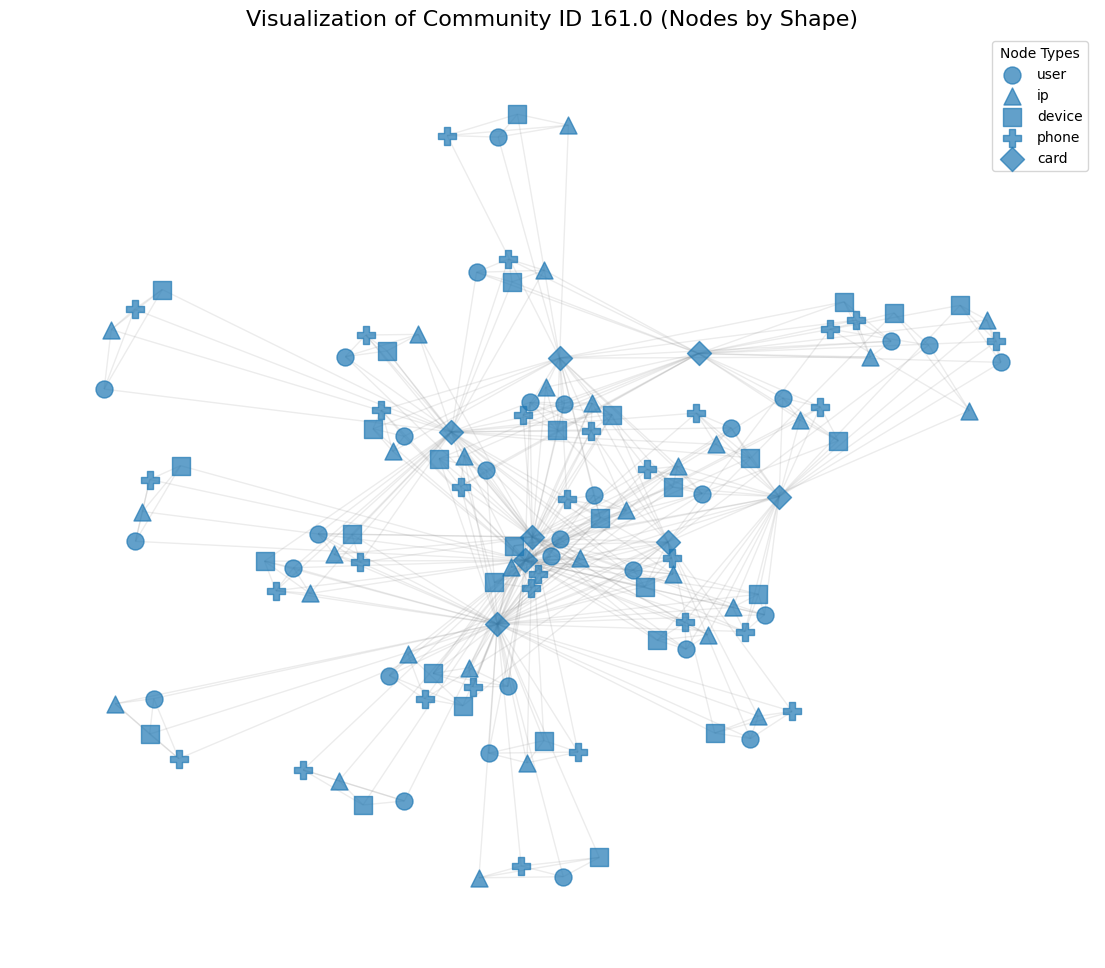

In [19]:

if 'G' in locals() and G is not None and 'partition' in locals() and partition is not None and \
   'community_details_df_sorted' in locals() and not community_details_df_sorted.empty:
    
    # Select the ID of the largest community from our analysis
    target_community_id_viz = community_details_df_sorted.iloc[0]['Community ID']
    print(f"\nVisualizing the largest community (ID: {target_community_id_viz})...")

    # Get all nodes belonging to this target community
    community_nodes_viz = [node for node, comm_id in partition.items() if comm_id == target_community_id_viz]
    
    if community_nodes_viz:
        community_subgraph_viz = G.subgraph(community_nodes_viz) # Create the subgraph

        print(f"Number of nodes in this community subgraph: {community_subgraph_viz.number_of_nodes()}")
        print(f"Number of edges in this community subgraph: {community_subgraph_viz.number_of_edges()}")

        plt.figure(figsize=(14, 12)) # Adjust figure size for better visualization
        
        # Define marker shapes for different node types
        # Common markers: 'o' (circle), '^' (triangle_up), 's' (square), 'P' (plus_filled), '*' (star), 'D' (diamond)
        node_type_markers = {
            'user': 'o', 
            'ip': '^', 
            'device': 's', 
            'phone': 'P', 
            'card': 'D'
        }
        default_marker = 'X' # Fallback marker for unknown types

        # Prepare lists for drawing nodes of different types separately for legend creation
        # and to apply different markers
        
        # Use a layout algorithm for positioning nodes
        # k parameter in spring_layout controls the optimal distance between nodes.
        # iterations controls the number of iterations of the Fruchterman-Reingold algorithm.
        pos_community = nx.spring_layout(community_subgraph_viz, k=0.2, iterations=30, seed=42)

        # Draw nodes for each type with its specific marker
        for node_type, marker_shape in node_type_markers.items():
            nodelist = [node for node in community_subgraph_viz.nodes() 
                        if community_subgraph_viz.nodes[node].get('type') == node_type]
            if nodelist: # Only draw if nodes of this type exist in the subgraph
                nx.draw_networkx_nodes(community_subgraph_viz, pos_community, 
                                       nodelist=nodelist, 
                                       node_shape=marker_shape, 
                                       node_size=150, # Adjust size as needed
                                       label=node_type, # Label for legend
                                       alpha=0.7)

        # Draw edges
        nx.draw_networkx_edges(community_subgraph_viz, pos_community, alpha=0.15, edge_color='grey')
        
        plt.title(f"Visualization of Community ID {target_community_id_viz} (Nodes by Shape)", fontsize=16)
        plt.legend(scatterpoints=1, title="Node Types", loc='upper right', markerscale=1, fontsize=10)
        plt.axis('off') # Turn off the axis for a cleaner graph visualization
        plt.show()
    else:
        print(f"No nodes found for community ID {target_community_id_viz} to visualize.")
else:
    print("Graph, partition, or community details DataFrame not available. Skipping community visualization.")

In [12]:
import networkx as nx # Assuming NetworkX is imported

if transactions_df is not None:
    G = nx.Graph() # Initialize an empty undirected graph

    # Define which columns represent entities that will become nodes
    # We'll prefix entity type to avoid ID collisions, e.g., 'user_0', 'ip_219.20.206.172'
    node_types_and_columns = {
        'user': 'user_id',
        'ip': 'ip',
        'device': 'device_id',
        'phone': 'phone_number',
        'card': 'credit_card_number'
        # 'transaction' itself could also be a node type if desired
    }

    # Add nodes with type attribute
    for node_type, col_name in node_types_and_columns.items():
        for entity_id in transactions_df[col_name].unique():
            G.add_node(f"{node_type}_{entity_id}", type=node_type)

    # Add edges based on co-occurrence in transactions
    # For each transaction, connect all involved entities to each other
    # This creates a dense set of connections per transaction
    # A transaction_id node could also be used as a central hub for each transaction's entities
    
    print("Adding edges to the graph based on transactions...")
    for index, row in transactions_df.iterrows():
        transaction_entities = []
        for node_type, col_name in node_types_and_columns.items():
            transaction_entities.append(f"{node_type}_{row[col_name]}")
        
        # Create edges between all pairs of entities within this transaction
        # For example, if entities are [A, B, C], create edges (A,B), (A,C), (B,C)
        from itertools import combinations
        for node1, node2 in combinations(transaction_entities, 2):
            if G.has_edge(node1, node2):
                G.edges[node1, node2]['weight'] = G.edges[node1, node2].get('weight', 0) + 1
                G.edges[node1, node2]['transactions'] = G.edges[node1, node2].get('transactions', []) + [row['transaction_id']]
            else:
                G.add_edge(node1, node2, weight=1, transactions=[row['transaction_id']])
        if index % 1000 == 0 and index > 0: # Progress update
            print(f"Processed {index} transactions for graph building...")

    print("\nGraph construction completed.")
    print(f"Number of nodes in the graph: {G.number_of_nodes()}")
    print(f"Number of edges in the graph: {G.number_of_edges()}")
else:
    print("transactions_df not loaded. Skipping graph construction.")
    G = None

Adding edges to the graph based on transactions...
Processed 1000 transactions for graph building...
Processed 2000 transactions for graph building...
Processed 3000 transactions for graph building...
Processed 4000 transactions for graph building...
Processed 5000 transactions for graph building...
Processed 6000 transactions for graph building...
Processed 7000 transactions for graph building...
Processed 8000 transactions for graph building...
Processed 9000 transactions for graph building...
Processed 10000 transactions for graph building...
Processed 11000 transactions for graph building...
Processed 12000 transactions for graph building...
Processed 13000 transactions for graph building...
Processed 14000 transactions for graph building...

Graph construction completed.
Number of nodes in the graph: 14906
Number of edges in the graph: 30567


In [13]:
# Ensure NetworkX (nx) and community_louvain are imported
# import community.community_louvain as community_louvain 

if G is not None:
    print("\nPerforming Louvain community detection...")
    # You might need to install python-louvain: pip install python-louvain
    try:
        import community.community_louvain as community_louvain
        partition = community_louvain.best_partition(G, random_state=42) # Compute the best partition
        
        # Add community ID as a node attribute
        nx.set_node_attributes(G, partition, 'community_id')
        
        num_communities = len(set(partition.values()))
        print(f"Louvain algorithm detected {num_communities} communities.")

        # Count nodes per community for a quick overview
        community_counts = pd.Series(partition).value_counts().sort_values(ascending=False)
        print("\nTop 5 largest communities (Community ID: Number of Nodes):")
        display(community_counts.head())
        
    except ImportError:
        print("Error: 'community_louvain' library not found. Please install it using 'pip install python-louvain'.")
        partition = None
    except Exception as e:
        print(f"An error occurred during community detection: {e}")
        partition = None
else:
    print("Graph G not available. Skipping community detection.")


Performing Louvain community detection...
Louvain algorithm detected 2913 communities.

Top 5 largest communities (Community ID: Number of Nodes):


190    128
203    125
37     103
24       5
91       5
Name: count, dtype: int64


Analyzing the largest community (ID: 190)...
Number of nodes in selected community: 128
Number of edges in selected community: 464

Node type distribution in this community:


user      30
ip        30
device    30
phone     30
card       8
Name: count, dtype: int64

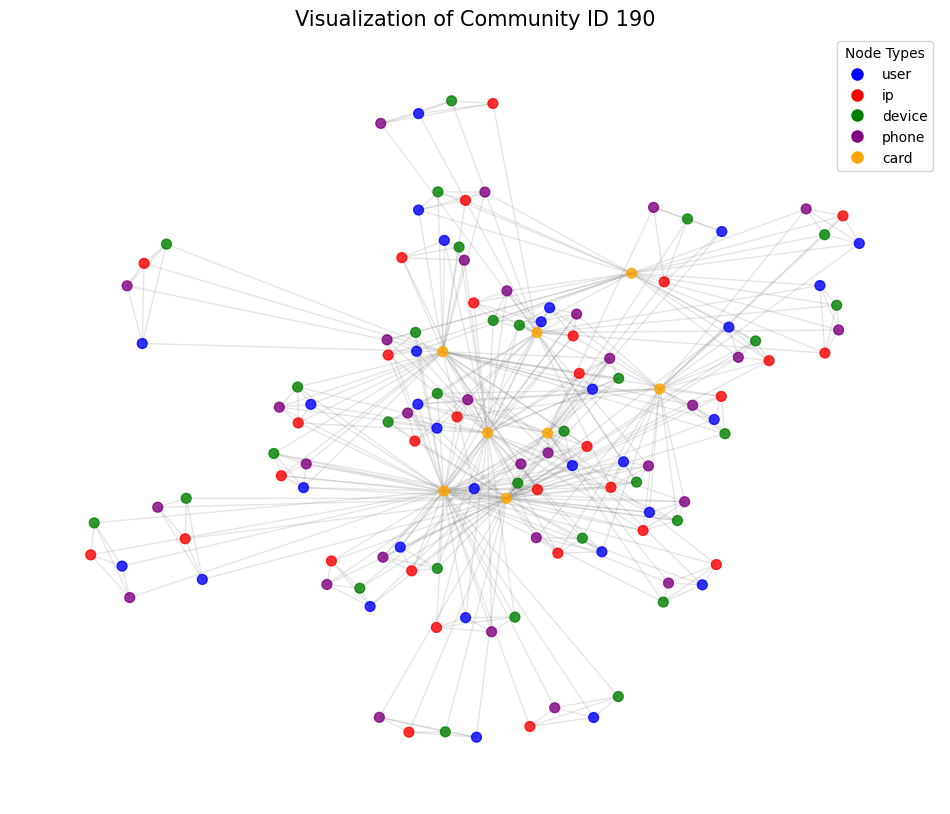

In [14]:
# Ensure G, partition, and other libraries (matplotlib.pyplot as plt, seaborn as sns) are available

if G is not None and partition is not None:
    # Example: Select one of the larger communities for closer inspection
    # Let's assume community_counts from Listing 9.3 is available
    if 'community_counts' in locals() and not community_counts.empty:
        target_community_id = community_counts.index[0] # Analyze the largest community
        print(f"\nAnalyzing the largest community (ID: {target_community_id})...")

        # Create a subgraph of this community
        community_nodes = [node for node, comm_id in partition.items() if comm_id == target_community_id]
        community_graph = G.subgraph(community_nodes)

        print(f"Number of nodes in selected community: {community_graph.number_of_nodes()}")
        print(f"Number of edges in selected community: {community_graph.number_of_edges()}")

        # Analyze node type distribution within this community
        node_types_in_community = [community_graph.nodes[node]['type'] for node in community_graph.nodes()]
        print("\nNode type distribution in this community:")
        display(pd.Series(node_types_in_community).value_counts())

        # Visualize this community subgraph
        plt.figure(figsize=(12, 10))
        pos = nx.spring_layout(community_graph, k=0.15, iterations=20, seed=42) # Layout for the subgraph
        
        # Define colors for different node types for visualization
        node_type_colors = {'user': 'blue', 'ip': 'red', 'device': 'green', 'phone': 'purple', 'card': 'orange'}
        node_colors = [node_type_colors.get(community_graph.nodes[node]['type'], 'grey') for node in community_graph.nodes()]
        
        nx.draw_networkx_nodes(community_graph, pos, node_color=node_colors, node_size=50, alpha=0.8)
        nx.draw_networkx_edges(community_graph, pos, alpha=0.2, edge_color='grey')
        # nx.draw_networkx_labels(community_graph, pos, font_size=8) # Labels can make it cluttered

        # Create a legend for node types
        from matplotlib.lines import Line2D
        legend_elements = [Line2D([0], [0], marker='o', color='w', label=ntype,
                                  markerfacecolor=ncolor, markersize=10) 
                           for ntype, ncolor in node_type_colors.items()]
        plt.legend(handles=legend_elements, title="Node Types", loc='upper right')
        
        plt.title(f"Visualization of Community ID {target_community_id}", fontsize=15)
        plt.axis('off')
        plt.show()
    else:
        print("Community counts not available to select a target community.")
else:
    print("Graph G or partition not available for community analysis and visualization.")